# Predicting Unknown Data With Optimized Model Parameters

In this notebook, the following happens: 
- Complete unknown, prepared test data is loaded
- An optimized model is loaded
- y values are predicted
- y values are saved

## Parameter

In [1]:
import os

use_training_settings = False  #Use training or test settings

if use_training_settings == True:
    ### TRAINING SETTINGS ###
    print("Use settings to predict training data")
    dataset_name = "omxs30"
    class_name = "LongTrend"
    filenametrainsuffix = ""
    filenametestsuffix = ""

    display_labelled_data = True #Set this true if labelled test data shall be displayed, Set false if no labels are available

    filetestdataresultdirectory = '02_Training_Data'
    filetraindataresultdirectory = '02_Training_Data' #Difference
    modelresultdirectory = '04_Model'
    finalresultdirectory = '05_Results'
    
else:
    ### TEST SETTINGS ###
    dataset_name = "omxs30"
    class_name = "LongTrend"
    filenametrainsuffix = ""
    filenametestsuffix = "_test"

    display_labelled_data = False #Set this true if labelled test data shall be displayed, Set false if no labels are available
    
    filetraindataresultdirectory = '02_Training_Data'
    filetestdataresultdirectory = '03_Test_Prepared_Data' #Difference
    modelresultdirectory = '04_Model'
    finalresultdirectory = '05_Results'


In [2]:
#Constructed paths
filenametrainprefix = dataset_name + "_" + class_name
#filenametestprefix = filenametrainprefix
#filenameXtrainsuffix = filenametrainsuffix
#filenameysuffix = filenametrainsuffix
#filenamelabelledysuffix = ''

X_filename_test = filetestdataresultdirectory + "/" + filenametrainprefix + "_X" + filenametestsuffix + ".csv"
y_filename_test = filetestdataresultdirectory + "/" + filenametrainprefix + "_y" + filenametestsuffix + ".csv"

y_pred_filename = finalresultdirectory + "/" + filenametrainprefix + "_y" + filenametestsuffix + "_prediction.csv"
ylabel_filename = filetraindataresultdirectory + "/" + filenametrainprefix + "_y" + "_labels_model.csv"
X_filename_selected_feature_column = filetraindataresultdirectory + "/" + filenametrainprefix + "_X" + filenametrainsuffix + "_selected_feature_columns.csv"
filename_timegraph = filetestdataresultdirectory + "/" + filenametrainprefix + "_timegraph" + filenametestsuffix + ".csv"


model_filename =  os.getcwd() + "/" + modelresultdirectory + "/" + filenametrainprefix + "_final_model" + filenametrainsuffix + ".sav"
external_parameters_filename = modelresultdirectory + "/" + filenametrainprefix + "_final_model_ext_parameters" + filenametrainsuffix + ".json"

print("X test: ", X_filename_test)
print("Display labelled test data: ", display_labelled_data)
print("y test: ", y_filename_test)
print("y predicted: ", y_pred_filename)
print("y label: ", ylabel_filename)
print("feature columns: ", X_filename_selected_feature_column)
print("Model to load: ", model_filename)
print("External parameters to load: ", external_parameters_filename)

X test:  03_Test_Prepared_Data/omxs30_LongTrend_X_test.csv
Display labelled test data:  False
y test:  03_Test_Prepared_Data/omxs30_LongTrend_y_test.csv
y predicted:  05_Results/omxs30_LongTrend_y_test_prediction.csv
y label:  02_Training_Data/omxs30_LongTrend_y_labels_model.csv
feature columns:  02_Training_Data/omxs30_LongTrend_X_selected_feature_columns.csv
Model to load:  C:\Users\wendt.ICT\Documents\Alexander\03_PythonProjects\04_Machine_Learning_Toolbox\machine_learning_toolbox/04_Model/omxs30_LongTrend_final_model.sav
External parameters to load:  04_Model/omxs30_LongTrend_final_model_ext_parameters.json


## Imports

In [3]:
#Imports
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as m
#from sklearn.externals import joblib
import joblib
import matplotlib.dates as mdates
import datetime

import DataSupportFunctions as sup
import DatavisualizationFunctions as vis

import json

from sklearn.model_selection import train_test_split

#Global settings
np.set_printoptions(precision=3)

#Suppress print out in scientific notiation
np.set_printoptions(suppress=True)

#### Pipeline elements

In [4]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
# Column extractor object

class Nosampler(BaseEstimator, TransformerMixin):
    '''The nosampler class do not do any type of sampling. It shall be used to compare with common over, under and 
    combined samplers'''

    #def __init__(self):
        #self.cols = cols

    def transform(self, X):
        return X

    def fit(self, X, y=None):
        return self

#res = Nosampler().transform(X_train.values)
#display(res)
#X_train.values

In [5]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
# Column extractor object

class ColumnExtractor(BaseEstimator, TransformerMixin):
    '''Column extractor method to extract selected columns from a list. This is used as a feature selector. Source
    https://stackoverflow.com/questions/25250654/how-can-i-use-a-custom-feature-selection-function-in-scikit-learns-pipeline,
    http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/.'''

    def __init__(self, cols=[0]):
        self.cols = cols

    def transform(self, X):
        col_list = []
        if self.cols is not None:
            return X[:,self.cols]
        else:
            return X
        #for c in self.cols:
        #    col_list.append(X[:, c:c+1])
        #return np.concatenate(col_list, axis=1)
        #return X[self.cols].values

    def fit(self, X, y=None):
        return self

#X_train[['MA2Norm', 'MA5Norm']]
#colList = [0, 1]
#col = ColumnExtractor(cols=colList).transform(X_train.values)
#col

In [6]:
def getListFromColumn(df, df_source, col_number):
    col_names = list(df[df.columns[col_number]].dropna().values)
    col_index = [i for i, col in enumerate(df_source) if col in col_names]
    return col_index

#display(feature_dict)

#Index(pd.Series(data=list(df_X.columns))).get_loc(x)

## Load Unknown Data

In [7]:
#Load features from X
df_X = pd.read_csv(X_filename_test, delimiter=';').set_index('id')
print("Loaded feature names for X={}".format(df_X.columns))
print("X. Shape={}".format(df_X.shape))
print("Indexes of X={}".format(df_X.index.shape))

#Load y values
if display_labelled_data == True:
    df_y = pd.read_csv(y_filename_test, delimiter=';').set_index('id')
    y = df_y.values.flatten()
    print("Loaded y. Shape={}".format(y.shape))
else:
    print("No labelled data is loaded")

#Load original data for visualization
df_timegraph = pd.read_csv(filename_timegraph, delimiter=';').set_index('id')
df_timegraph['Time'] = pd.to_datetime(df_timegraph['Time'])
df_timegraph['Time'].apply(mdates.date2num)
print("Loaded feature names for time graph={}".format(df_timegraph.columns))
print("X. Shape={}".format(df_timegraph.shape))
display(df_timegraph.head())

#Load classes
df_y_classes = pd.read_csv(ylabel_filename, delimiter=';', header=None)
y_classes = sup.inverse_dict(df_y_classes.set_index(df_y_classes.columns[0]).to_dict()[1])
print("Loaded classes into dictionary: {}".format(y_classes))

#Load list of feature columns
df_feature_columns = pd.read_csv(X_filename_selected_feature_column, delimiter=';')
print("Selected features")
display(df_feature_columns)

model = joblib.load(model_filename)
print("Loaded trained model from ", model_filename)
print("Model", model)

#Load model external parameters
with open(external_parameters_filename, 'r') as fp:
    parameter_data = json.load(fp)
print("Loaded external parameters: ", parameter_data)
pr_threshold = parameter_data['pr_threshold']
print("Loaded precision/recall threshold: ", pr_threshold)

Loaded feature names for X=Index(['NormKurs5', 'NormKurs20', 'NormKurs50', 'NormKurs100', 'NormKurs200',
       'NumberRise5', 'NumberRise20', 'NumberRise50', 'NumberRise100',
       'NumberRise200',
       ...
       'month_year__9', 'month_year__10', 'month_year__11', 'month_year__12',
       'week_month__1', 'week_month__2', 'week_month__3', 'week_month__4',
       'week_month__5', 'week_month__6'],
      dtype='object', length=127)
X. Shape=(352, 127)
Indexes of X=(352,)
No labelled data is loaded
Loaded feature names for time graph=Index(['Time', 'High', 'Low', 'Close'], dtype='object')
X. Shape=(352, 4)


,Time,High,Low,Close
id,,,,
400,2018-08-07,1621.26,1610.52,1619.89
401,2018-08-08,1624.10,1614.73,1622.63
402,2018-08-09,1631.74,1618.72,1631.23
403,2018-08-10,1627.44,1613.39,1616.82
404,2018-08-13,1616.34,1607.81,1611.80


Loaded classes into dictionary: {0: 'Negative', 1: 'Positive'}
Selected features


,Lasso,Tree,Backward_Elimination,RecursiveTop32,RecursiveTop64,RecursiveTop96,Manual,All
0,MA150Norm,Stoch_Sd211414,NormKurs20,NormKurs200,NormKurs200,NormKurs200,MA100Norm,NormKurs5
1,NormKurs20,Stoch_Sk211414,NormKurs50,MA150Norm,MA150Norm,MA150Norm,MA125Norm,NormKurs20
2,NumberRise50,RSI20,NormKurs100,NumberRise200,NumberRise200,NumberRise200,MA150Norm,NormKurs50
3,NumberRise20,NormKurs50,NormKurs200,MA125Norm,MA125Norm,MA125Norm,MA175Norm,NormKurs100
4,NumberRise5,NumberRise200,NumberRise5,NumberRise50,NumberRise50,NumberRise50,MA200Norm,NormKurs200
...,...,...,...,...,...,...,...,...
122,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__2
123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__3
124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__4
125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,week_month__5


Loaded trained model from  C:\Users\wendt.ICT\Documents\Alexander\03_PythonProjects\04_Machine_Learning_Toolbox\machine_learning_toolbox/04_Model/omxs30_LongTrend_final_model.sav
Model Pipeline(memory=None,
         steps=[('scaler',
                 QuantileTransformer(copy=True, ignore_implicit_zeros=False,
                                     n_quantiles=1000,
                                     output_distribution='uniform',
                                     random_state=None, subsample=100000)),
                ('sampling', Nosampler()),
                ('feat',
                 ColumnExtractor(cols=[2, 3, 4, 7, 8, 9, 23, 24, 25, 26, 27, 28,
                                       29, 30, 31, 32, 33, 34, 35, 68, 85,
                                       86])),
                ('svm',
                 SVC(C=4.895467982642922, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=7.525818386930191, 

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [8]:
# Create adjusted precision-recall curves
# https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [9]:
selected_features = [getListFromColumn(df_feature_columns, df_X, i) for i in range(0, df_feature_columns.shape[1])]
feature_dict = dict(zip(df_feature_columns.columns, selected_features))

## Predict new Trend

#### Prediction

In [10]:
optclf = model
X=df_X

#y_test_pred = optclf.predict(X.values)
y_test_pred_scores = optclf.decision_function(X.values)
y_test_pred_proba = optclf.predict_proba(X.values)
print("Prediction complete")

Prediction complete


In [11]:
#Adjust for the optimal value of precision/recall curve
print("Selected threshold: ", pr_threshold)
y_test_pred_adjust = adjusted_classes(y_test_pred_scores, pr_threshold) # (y_test_pred_scores>=pr_threshold).astype('int')


y_order_test_pred = pd.DataFrame(index=X.index, data=pd.Series(data=y_test_pred_adjust, index=X.index, name="y")).sort_index()
y_order_scores = pd.DataFrame(index=X.index, data=pd.Series(data=y_test_pred_scores, index=X.index, name="y_scores")).sort_index()
y_order_proba = pd.DataFrame(index=X.index, data=pd.Series(data=y_test_pred_proba[:,1], index=X.index, name="y_probabilities")).sort_index()

result_compare = y_order_test_pred
result_compare = result_compare.join(y_order_scores['y_scores'])
result_compare = result_compare.join(y_order_proba['y_probabilities'])
result_compare.head()

Selected threshold:  0.13628008366959077


,y,y_scores,y_probabilities
id,,,
400,1,0.299996,0.598706
401,1,0.154790,0.543835
402,0,0.013097,0.490002
403,0,-0.226895,0.400631
404,0,-0.261311,0.388428


In [12]:
#Show metrics

%matplotlib inline

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

if display_labelled_data == True:
    #Prepare the class list for classes, in case a class does not exist in the y_true and y_pred, which exist in y_train
    a=np.unique(y)
    b=np.unique(y_order_test_pred)
    c=np.hstack((a, b))
    d=np.unique(c)
    existing_classes=[]
    [existing_classes.append(y_classes[i]) for i in d]
    existing_classes
    
    
    #Calculate Precision, Recall, Accuracy, F1, Confusion Matrix, ROC
    print("Accuracy: ", accuracy_score(y, y_order_test_pred))
    print(classification_report(y, y_order_test_pred, target_names=existing_classes))

    cnf_matrix = confusion_matrix(y, y_order_test_pred, labels=d)
    np.set_printoptions(precision=3)

    # Plot non-normalized confusion matrix
    matrixSize = len(y_classes)*2
    plt.figure(figsize=(matrixSize, matrixSize))
    _ = vis.plot_confusion_matrix_multiclass(cnf_matrix, classes=existing_classes, title='Confusion matrix with normalization', normalize=True)
    plt.show()

    plt.figure(figsize=(12, 8))
    print("Plot ROC curve")
    _ = skplt.metrics.plot_roc(np.array(y), np.array(y_test_pred_proba))
    plt.show()

In [13]:
#Store prediction
#Save y to a csv file
print("y prediction shape {}".format(y_order_test_pred.shape))
y_order_test_pred.to_csv(y_pred_filename, sep=';', index=True, header=True)
print("Saved features to " + y_pred_filename)

y prediction shape (352, 1)
Saved features to 05_Results/omxs30_LongTrend_y_test_prediction.csv


## Visualize Results

In [14]:
#def amplifyForPlot(binaryArray, targetArray, distance):
#    result = binaryArray * targetArray * (1-distance)
#    return result

C:\Users\wendt.ICT\.conda\envs\env_ml\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


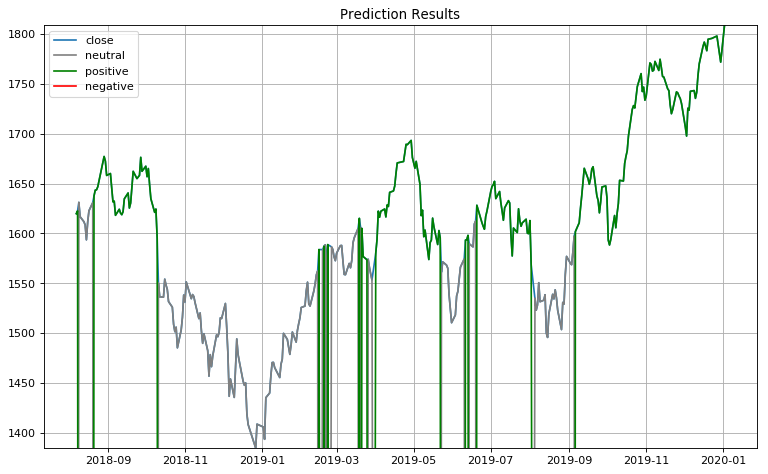

In [15]:
#Present long term term data

#Plot the 3 class graph
vis.plot_three_class_graph(y_order_test_pred['y'].values, 
                       df_timegraph['Close'][y_order_test_pred.index], 
                       df_timegraph['Time'][y_order_test_pred.index], 0,0,0,('close', 'neutral', 'positive', 'negative'))

# Add ground truth to training data
if display_labelled_data == True:
    plt.plot(df_timegraph['Time'], vis.amplifyForPlot(y, df_timegraph['Close'].values, 0.0), color='blue')

In [16]:
s = df_timegraph.join(y_order_test_pred['y'])
if display_labelled_data == True:
    s=s.join(df_y)
s.tail(50)

,Time,High,Low,Close,y
id,,,,,
702,2019-10-18,1699.32,1673.51,1697.91,1
703,2019-10-21,1725.31,1696.35,1724.36,1
704,2019-10-22,1734.71,1724.38,1728.22,1
705,2019-10-23,1726.52,1712.77,1725.87,1
706,2019-10-24,1737.46,1720.37,1736.98,1
707,2019-10-25,1747.30,1732.26,1747.30,1
708,2019-10-28,1761.83,1746.32,1760.31,1
709,2019-10-29,1760.26,1738.14,1742.32,1
710,2019-10-30,1750.04,1736.89,1746.81,1


# Debug

%matplotlib notebook

plot_data = amplifyForPlot(y_order_test_pred['y'].values-0.5, df_timegraph['Close'].values, 0.0)

inverse_values = (y_order_test_pred['y'].values-1)*(-1)

#Plot test data
plt.figure(num=None, figsize=(11.5, 7), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df_timegraph['Time'], df_timegraph['Close'])
plt.plot(df_timegraph['Time'], amplifyForPlot(y_order_test_pred['y'].values, df_timegraph['Close'].values, 0.0), color='green')
plt.plot(df_timegraph['Time'], amplifyForPlot(inverse_values, df_timegraph['Close'].values, 0.0), color='red')
if display_labelled_data == True:
    plt.plot(df_timegraph['Time'], amplifyForPlot(y, df_timegraph['Close'].values, 0.0), color='yellow')
plt.title("Prediction Results")
plt.ylim([np.min(df_timegraph['Close'].values)*0.99, np.max(df_timegraph['Close'].values)*1.02])
plt.grid()
plt.legend(['Close', 'Pos. Trend', 'Neg. Trend', 'Pos. Trend true value'])
plt.show()